In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Add, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, InputLayer, GlobalAveragePooling2D ,Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

plt.rcParams['font.size'] = 14

In [10]:
img_size = 224
batch_size = 32


train_datagen = ImageDataGenerator(rescale = 1/255.,brightness_range=[0.5,1.5], zoom_range=0.2, 
                                   width_shift_range =0.15, height_shift_range =0.15, horizontal_flip=True )
val_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)


train_generator = train_datagen.flow_from_directory('D:/dataset2-master/dataset2-master/images/TRAIN',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=True,
                                                   class_mode='sparse')

val_generator = val_datagen.flow_from_directory('D:/dataset2-master/dataset2-master/images/TEST_SIMPLE',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='sparse')

test_generator = test_datagen.flow_from_directory('D:/dataset2-master/dataset2-master/images/TEST',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode = "sparse")

Found 9957 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


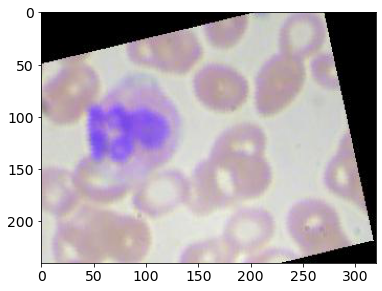

In [20]:
from glob import glob #retriving an array of files in directories
path_train = "D:/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL"
img = glob(path_train+"/*.jpeg")
# print(img)
img = np.asarray(plt.imread(img[135]))
plt.figure(figsize = (6, 6))
plt.imshow(img)
plt.show()

In [4]:
def residual_block(x, kernel_size, filters, s=2):
    f1,f2,f3 = filters
    x_shortcut = x
    
    # Shortcut Path
    x_shortcut = Conv2D(f3, kernel_size=(1,1), strides=(s,s), padding='valid')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    
    # Main Path
    # First Component
    x = Conv2D(f1, kernel_size=(1,1), strides=(s,s), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second Component
    x = Conv2D(f2, kernel_size=kernel_size, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Third Component
    x = Conv2D(f3, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x012

In [5]:
input_layer = Input(shape=(224,224,3))
x = Conv2D(64, kernel_size=(7,7), strides=(2,2))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3), strides=(2,2))(x)

x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)

x = residual_block(x,3,[128,128,512])
x = residual_block(x,3,[128,128,512])
x = residual_block(x,3,[128,128,512])

x = residual_block(x,3,[256,256,1024])
x = residual_block(x,3,[256,256,1024])
x = residual_block(x,3,[256,256,1024])

# x = residual_block(x,3,[512,512,2048])
# x = residual_block(x,3,[512,512,2048])
# x = residual_block(x,3,[512,512,2048])

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
output_layer = Dense(4, activation='softmax')(x)

resnet50 = Model(inputs=input_layer,outputs=output_layer)

In [6]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 109, 109, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_11 (BatchN  (None, 54, 54, 64)  256         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 54, 54, 64)   0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 54, 54, 128)  8320        ['activation_8[0][0]']           
                                                                                                  
 conv2d_9 (Conv2D)              (None, 54, 54, 128)  16512       ['activation_6[0][0]']           
                                                                                                  
 batch_nor

                                                                                                  
 activation_16 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 7, 7, 128)    147584      ['activation_16[0][0]']          
                                                                                                  
 batch_normalization_23 (BatchN  (None, 7, 7, 128)   512         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_23[0][0]'] 
                                                                                                  
 conv2d_24

 conv2d_34 (Conv2D)             (None, 1, 1, 256)    262400      ['activation_24[0][0]']          
                                                                                                  
 batch_normalization_34 (BatchN  (None, 1, 1, 256)   1024        ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_25 (Activation)     (None, 1, 1, 256)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 1, 1, 256)    590080      ['activation_25[0][0]']          
                                                                                                  
 batch_normalization_35 (BatchN  (None, 1, 1, 256)   1024        ['conv2d_35[0][0]']              
 ormalizat

In [7]:
# Uncomment to see the model as a figure
# tf.keras.utils.plot_model(resnet50,to_file='resnet50.png')

In [8]:
checkpoint_filepath = 'C:/Users/Deek/Downloads/tmp/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)


In [9]:
# loss = tf.keras.losses.sparse_categorical_crossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
resnet50.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [10]:
# Train the model
history = resnet50.fit(train_generator,
                        epochs=50,
                        validation_data=val_generator,
                        callbacks=[checkpoint,earlystopping])

Epoch 1/50
312/312 [==============================] - ETA: 0s - loss: 1.6794 - accuracy: 0.2552
Epoch 1: val_loss improved from inf to 1.61151, saving model to C:/Users/Deek/Downloads/tmp\checkpoint


INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


312/312 [==============================] - 1111s 4s/step - loss: 1.6794 - accuracy: 0.2552 - val_loss: 1.6115 - val_accuracy: 0.1408
Epoch 2/50
312/312 [==============================] - ETA: 0s - loss: 1.5766 - accuracy: 0.2574
Epoch 2: val_loss improved from 1.61151 to 1.35225, saving model to C:/Users/Deek/Downloads/tmp\checkpoint


INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


312/312 [==============================] - 1120s 4s/step - loss: 1.5766 - accuracy: 0.2574 - val_loss: 1.3523 - val_accuracy: 0.3099
Epoch 3/50
312/312 [==============================] - ETA: 0s - loss: 1.5054 - accuracy: 0.2722
Epoch 3: val_loss did not improve from 1.35225
312/312 [==============================] - 1117s 4s/step - loss: 1.5054 - accuracy: 0.2722 - val_loss: 1.7269 - val_accuracy: 0.1268
Epoch 4/50
312/312 [==============================] - ETA: 0s - loss: 1.4366 - accuracy: 0.2990
Epoch 4: val_loss did not improve from 1.35225
312/312 [==============================] - 2181s 7s/step - loss: 1.4366 - accuracy: 0.2990 - val_loss: 1.6351 - val_accuracy: 0.1127
Epoch 5/50
312/312 [==============================] - ETA: 0s - loss: 1.3206 - accuracy: 0.3680
Epoch 5: val_loss did not improve from 1.35225
312/312 [==============================] - 1140s 4s/step - loss: 1.3206 - accuracy: 0.3680 - val_loss: 8.4829 - val_accuracy: 0.0563
Epoch 6/50
312/312 [===================

INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


312/312 [==============================] - 1245s 4s/step - loss: 1.1258 - accuracy: 0.4826 - val_loss: 0.9055 - val_accuracy: 0.6901
Epoch 7/50
312/312 [==============================] - ETA: 0s - loss: 0.9967 - accuracy: 0.5530
Epoch 7: val_loss did not improve from 0.90552
312/312 [==============================] - 1355s 4s/step - loss: 0.9967 - accuracy: 0.5530 - val_loss: 1.1692 - val_accuracy: 0.3099
Epoch 8/50
312/312 [==============================] - ETA: 0s - loss: 0.8877 - accuracy: 0.6036
Epoch 8: val_loss did not improve from 0.90552
312/312 [==============================] - 1142s 4s/step - loss: 0.8877 - accuracy: 0.6036 - val_loss: 1.1341 - val_accuracy: 0.3662
Epoch 9/50
312/312 [==============================] - ETA: 0s - loss: 0.7845 - accuracy: 0.6517
Epoch 9: val_loss improved from 0.90552 to 0.70781, saving model to C:/Users/Deek/Downloads/tmp\checkpoint


INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


312/312 [==============================] - 1118s 4s/step - loss: 0.7845 - accuracy: 0.6517 - val_loss: 0.7078 - val_accuracy: 0.7183
Epoch 10/50
312/312 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.6724
Epoch 10: val_loss did not improve from 0.70781
312/312 [==============================] - 1141s 4s/step - loss: 0.7291 - accuracy: 0.6724 - val_loss: 0.7601 - val_accuracy: 0.6056
Epoch 11/50
312/312 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.7034
Epoch 11: val_loss did not improve from 0.70781
312/312 [==============================] - 1249s 4s/step - loss: 0.6723 - accuracy: 0.7034 - val_loss: 0.9099 - val_accuracy: 0.6620
Epoch 12/50
312/312 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.7231
Epoch 12: val_loss did not improve from 0.70781
312/312 [==============================] - 1183s 4s/step - loss: 0.6358 - accuracy: 0.7231 - val_loss: 1.8616 - val_accuracy: 0.6901
Epoch 13/50
312/312 [============

INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


312/312 [==============================] - 1179s 4s/step - loss: 0.5854 - accuracy: 0.7462 - val_loss: 0.4904 - val_accuracy: 0.8310
Epoch 14/50
312/312 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.7718
Epoch 14: val_loss did not improve from 0.49035
312/312 [==============================] - 1132s 4s/step - loss: 0.5257 - accuracy: 0.7718 - val_loss: 1.4948 - val_accuracy: 0.3099
Epoch 15/50
312/312 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.7986
Epoch 15: val_loss did not improve from 0.49035
312/312 [==============================] - 1356s 4s/step - loss: 0.4800 - accuracy: 0.7986 - val_loss: 1.3546 - val_accuracy: 0.4930
Epoch 16/50
312/312 [==============================] - ETA: 0s - loss: 0.4272 - accuracy: 0.8208
Epoch 16: val_loss improved from 0.49035 to 0.46111, saving model to C:/Users/Deek/Downloads/tmp\checkpoint


INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


INFO:tensorflow:Assets written to: C:/Users/Deek/Downloads/tmp\checkpoint\assets


312/312 [==============================] - 1306s 4s/step - loss: 0.4272 - accuracy: 0.8208 - val_loss: 0.4611 - val_accuracy: 0.7746
Epoch 17/50
312/312 [==============================] - ETA: 0s - loss: 0.4368 - accuracy: 0.8224
Epoch 17: val_loss did not improve from 0.46111
312/312 [==============================] - 1145s 4s/step - loss: 0.4368 - accuracy: 0.8224 - val_loss: 0.9230 - val_accuracy: 0.5915
Epoch 18/50
312/312 [==============================] - ETA: 0s - loss: 0.3600 - accuracy: 0.8520
Epoch 18: val_loss did not improve from 0.46111
312/312 [==============================] - 1137s 4s/step - loss: 0.3600 - accuracy: 0.8520 - val_loss: 0.4703 - val_accuracy: 0.7606
Epoch 19/50
312/312 [==============================] - ETA: 0s - loss: 0.3371 - accuracy: 0.8629
Epoch 19: val_loss did not improve from 0.46111
312/312 [==============================] - 1150s 4s/step - loss: 0.3371 - accuracy: 0.8629 - val_loss: 0.7245 - val_accuracy: 0.7746
Epoch 20/50
312/312 [============

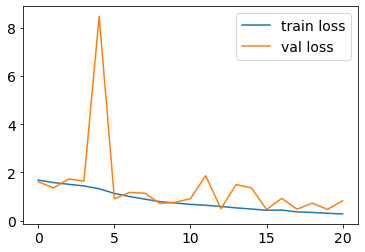

In [17]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

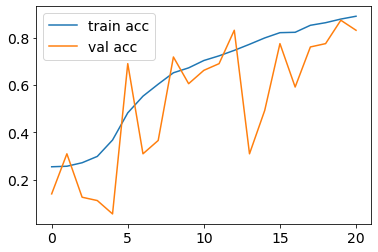

In [18]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [19]:
y_pred = resnet50.predict(test_generator).round()
y_test = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

78/78 [==============================] - 78s 996ms/step


In [21]:
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_test,y_pred,target_names = class_labels))

              precision    recall  f1-score   support

  EOSINOPHIL       0.87      0.60      0.71       623
  LYMPHOCYTE       0.97      0.94      0.95       620
    MONOCYTE       0.84      0.75      0.79       620
  NEUTROPHIL       0.60      0.87      0.71       624

    accuracy                           0.79      2487
   macro avg       0.82      0.79      0.79      2487
weighted avg       0.82      0.79      0.79      2487



In [22]:
print(accuracy_score(y_test, y_pred))


0.7893043827905106
